In [1]:
import sys
sys.executable = '/home/chao/anaconda3/envs/chemcheck_env/lib/python3.8/site-packages'
python_path = ['/home/chao/cantera/build/python', '/home/chao/RMG-Py', '/home/chao', '/home/chao/anaconda3/envs/chemcheck_env/lib/python38.zip', '/home/chao/anaconda3/envs/chemcheck_env/lib/python3.8', '/home/chao/anaconda3/envs/chemcheck_env/lib/python3.8/lib-dynload', '/home/chao/anaconda3/envs/chemcheck_env/lib/python3.8/site-packages']
sys.path.clear()
for path in python_path:
    sys.path.append(path)

In [2]:
import cantera as ct
import matplotlib.pyplot as plt
import numpy as np

In [3]:
"""
A simplest example to demonstrate the difference between Blowers-Masel
reaction and elementary reaction. First we set up 2 same reactions with
Arrhenius and Blowers-Masel rate parameters. The Blowers-Masel parameters
are same as Arrhenius parameters with an additional value -- bond energy.
First we show that the forward rate constants of 2 different reactions 
are different even if the rate parameters are same. Then we change the 
enthalpy of a species involved in all the reactions, and it shows that 
the Arrhenius forward rate constant does not change, and the Blowers-Masel 
forward rate constants change because the enthalpy change of the reactions
are changed. 
"""

import cantera as ct

#Create an elementary reaction
r1 = ct.ElementaryReaction({'O':1, 'H2':1}, {'H':1, 'OH':1})
r1.rate = ct.Arrhenius(3.87e1, 2.7, 6260*1000*4.184)

#Create a gas-phase Blowers-Masel reaction
r2 = ct.BlowersMaselReaction({'O':1, 'H2':1}, {'H':1, 'OH':1})
r2.rate = ct.BlowersMasel(3.87e1, 2.7, 6260*1000*4.184, 1e9)

#Create a Blowers-Masel reaction with same parameters with r2
r3 = ct.BlowersMaselReaction({'H':1, 'CH4':1}, {'CH3':1, 'H2':1})
r3.rate = ct.BlowersMasel(3.87e1, 2.7, 6260*1000*4.184, 1e9)

gas = ct.Solution(thermo='IdealGas', kinetics='GasKinetics',
                   species=ct.Solution('gri30.yaml').species(), reactions=[r1, r2, r3])

gas.TP = 300, ct.one_atm

print(gas.forward_rate_constants[0])

# Comparing the second and the third rate constants shows that
# even the rate parameters are same, the rate constants are 
# different due to the enthalpy change of the reactions are different
print(gas.forward_rate_constants[1])
print(gas.forward_rate_constants[2])

def change_species_enthalpy(gas, species_name, dH):
    """
    Find the species by name and change it's enthlapy by dH (in J/kmol)
    """
    index = gas.species_index(species_name)

    species = gas.species(index)
    # 'dx' is in fact (delta H / R). Note that R in cantera is 8314.462 J/kmol
    dx = dH / ct.gas_constant  
    perturbed_coeffs = species.thermo.coeffs.copy()
    perturbed_coeffs[6] += dx
    perturbed_coeffs[13] += dx
    
    species.thermo = ct.NasaPoly2(species.thermo.min_temp, species.thermo.max_temp, 
                            species.thermo.reference_pressure, perturbed_coeffs)

    gas.modify_species(index, species)

#change the enthalpy of species 'H' so that the reaction enthalpy changes
change_species_enthalpy(gas, 'H', 1e8)

# the rate constant of elementary should not change with enthalpy of the reaction
print(gas.forward_rate_constants[0])

# the rate constant of Blowers-Masel reaction changes with enthalpy of the reaction
print(gas.forward_rate_constants[1])
print(gas.forward_rate_constants[2])


5195.44737317942
946.0507745940208
2533.800177671109
5195.44737317942
2.768141491357371e-11
170072640.89839816


In [4]:
enthalpy_increase = np.arange(-1e10, 1e20, 1e20/100)
deltaH_list = []
Ea_list = []

In [5]:
# for temp in T_range:
#     gas.TP = temp, ct.one_atm
#     enthalpy_change = gas.delta_enthalpy[1]
#     Ea = gas.reaction(1).rate.activation_energy(enthalpy_change)
#     deltaH_list.append(enthalpy_change)
#     Ea_list.append(Ea)
for value in enthalpy_increase:
    change_species_enthalpy(gas, 'H', value)
    enthalpy_change = gas.delta_enthalpy[1]
    Ea = gas.reaction(1).rate.activation_energy(enthalpy_change)
    deltaH_list.append(enthalpy_change)
    Ea_list.append(Ea)

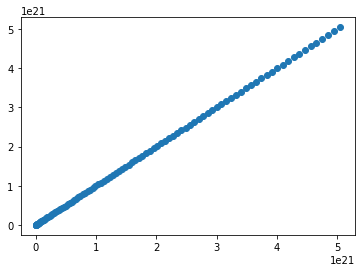

In [6]:
plt.scatter(deltaH_list, Ea_list)